Задание  
На вебинаре мы говорили что долгое время CNN и RNN архитектуры были конурируещими выяснить какая архитектура больше подходит для задачи сантимент анализа на данных с вебинара

In [1]:
!pip install stop_words

  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=e1fe4f817b44ba9fb1f7b224386c8526f233bd87ed9da349c97896964fa24a67
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [2]:
!pip install pymorphy2

     |████████████████████████████████| 55 kB 3.6 MB/s 
     |████████████████████████████████| 8.2 MB 20.7 MB/s 


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec, FastText

from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import utils
from tensorflow.keras import callbacks

In [4]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, concatenate, Flatten, add, MaxPool1D
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Masking, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import TensorBoard 
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
df_train = pd.read_csv('/content/drive/MyDrive/data/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/data/test.csv')
df_val = pd.read_csv('/content/drive/MyDrive/data/val.csv')

df_train.head()

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181467 entries, 0 to 181466
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      181467 non-null  int64 
 1   text    181467 non-null  object
 2   class   181467 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.2+ MB


Preprocessing text

In [7]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

df_train['text'] = df_train['text'].apply(preprocess_text)
df_val['text'] = df_val['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

In [8]:
text_corpus_train = df_train['text'].values
text_corpus_valid = df_val['text'].values
text_corpus_test = df_test['text'].values

In [9]:
tokenizer = Tokenizer(num_words=None, 
                     filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n',
                     lower = False, split = ' ')
tokenizer.fit_on_texts(text_corpus_train)

sequences_train = tokenizer.texts_to_sequences(text_corpus_train)
sequences_val = tokenizer.texts_to_sequences(text_corpus_valid)
sequences_test = tokenizer.texts_to_sequences(text_corpus_test)

word_count = len(tokenizer.index_word) + 1
training_length = max([len(i.split()) for i in text_corpus_train])

X_train = pad_sequences(sequences_train, maxlen=training_length)
X_valid = pad_sequences(sequences_val, maxlen=training_length)

In [10]:
y_train = df_train['class'].values
y_val = df_val['class'].values

LSTM Models

In [11]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(LSTM(64, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 27, 30)            7743240   
_________________________________________________________________
masking (Masking)            (None, 27, 30)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24320     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 7,771,785
Trainable params: 7,771,785
Non-trainable params: 0
______________________________________________

In [12]:
model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=3,
                    verbose=1,
                    validation_split=0.1)
                    #callbacks=[early_stopping]) jвылетает на первой, обучил на 3



Epoch 1/3
319/319 [==============================] - 75s 216ms/step - loss: 0.5563 - accuracy: 0.7028 - val_loss: 0.4936 - val_accuracy: 0.7524
Epoch 2/3
319/319 [==============================] - 68s 214ms/step - loss: 0.3282 - accuracy: 0.8631 - val_loss: 0.5238 - val_accuracy: 0.7499
Epoch 3/3
319/319 [==============================] - 68s 213ms/step - loss: 0.1528 - accuracy: 0.9431 - val_loss: 0.6952 - val_accuracy: 0.7389


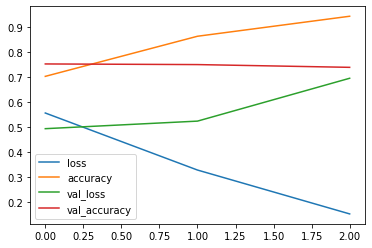

In [13]:
pd.DataFrame(history.history).plot()

In [14]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 1s 15ms/step - loss: 0.7757 - accuracy: 0.7273


Test score: 0.7756819128990173
Test accuracy: 0.7272847294807434


In [15]:
inputs = Input(shape=(X_train.shape[1],))

x =     Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True)(inputs)

xbi = Bidirectional(LSTM(15, return_sequences=True))(x)
x = add([x, xbi])

x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)



model = Model(inputs=inputs, outputs=x)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
early_stopping=EarlyStopping(monitor='val_loss')  


history_1 = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=3,
                    verbose=1,
                    validation_split=0.1)
                    #callbacks=[early_stopping])

Epoch 1/3
319/319 [==============================] - 82s 233ms/step - loss: 0.5514 - accuracy: 0.7077 - val_loss: 0.4865 - val_accuracy: 0.7586
Epoch 2/3
319/319 [==============================] - 71s 224ms/step - loss: 0.3000 - accuracy: 0.8775 - val_loss: 0.5482 - val_accuracy: 0.7476
Epoch 3/3
319/319 [==============================] - 72s 224ms/step - loss: 0.1259 - accuracy: 0.9539 - val_loss: 0.6875 - val_accuracy: 0.7400


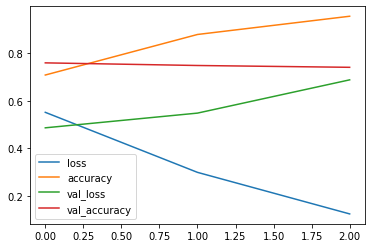

In [17]:
pd.DataFrame(history_1.history).plot()

In [18]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 1s 20ms/step - loss: 0.7412 - accuracy: 0.7249


Test score: 0.7412406802177429
Test accuracy: 0.7249482274055481


CNN Model

In [19]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dense(1))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 27, 30)            7743240   
_________________________________________________________________
conv1d (Conv1D)              (None, 25, 128)           11648     
_________________________________________________________________
activation (Activation)      (None, 25, 128)           0         
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [20]:
model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=3,
                    verbose=1,
                    validation_split=0.1)
                    #callbacks=[early_stopping])

Epoch 1/3
319/319 [==============================] - 56s 86ms/step - loss: 0.5488 - accuracy: 0.5076 - val_loss: 0.4904 - val_accuracy: 0.5049
Epoch 2/3
319/319 [==============================] - 27s 85ms/step - loss: 0.2967 - accuracy: 0.5076 - val_loss: 0.5424 - val_accuracy: 0.5049
Epoch 3/3
319/319 [==============================] - 27s 84ms/step - loss: 0.1060 - accuracy: 0.5076 - val_loss: 0.7055 - val_accuracy: 0.5049


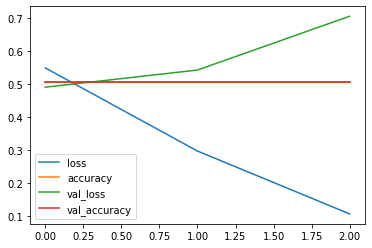

In [22]:
pd.DataFrame(history.history).plot()

In [23]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 0s 4ms/step - loss: 0.8014 - accuracy: 0.5047


Test score: 0.8013607263565063
Test accuracy: 0.5047392249107361


CNN -> LSTM

In [24]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(Conv1D(128, 3, activation='relu', padding="same"))
model.add(LSTM(64, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 27, 30)            7743240   
_________________________________________________________________
masking_1 (Masking)          (None, 27, 30)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 27, 128)           11648     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [25]:
model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=3,
                    verbose=1,
                    validation_split=0.1)
                    #callbacks=[early_stopping])

Epoch 1/3
319/319 [==============================] - 65s 196ms/step - loss: 0.5509 - accuracy: 0.7077 - val_loss: 0.4891 - val_accuracy: 0.7563
Epoch 2/3
319/319 [==============================] - 62s 195ms/step - loss: 0.2984 - accuracy: 0.8763 - val_loss: 0.5444 - val_accuracy: 0.7439
Epoch 3/3
319/319 [==============================] - 62s 194ms/step - loss: 0.1276 - accuracy: 0.9526 - val_loss: 0.7118 - val_accuracy: 0.7317


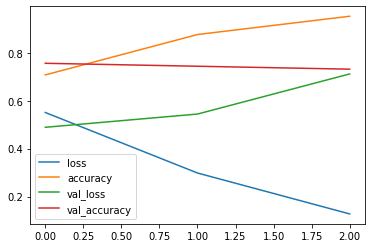

In [27]:
pd.DataFrame(history.history).plot()

In [28]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 1s 14ms/step - loss: 0.7702 - accuracy: 0.7283


Test score: 0.7701640129089355
Test accuracy: 0.7282546162605286


LSTM -> CNN

In [29]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model.add(Masking(mask_value=0.0))
model.add(LSTM(64, return_sequences=True))
model.add(Conv1D(64, 3, activation='relu', padding="same"))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 27, 30)            7743240   
_________________________________________________________________
masking_2 (Masking)          (None, 27, 30)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 27, 64)            24320     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 27, 64)            12352     
_________________________________________________________________
dense_8 (Dense)              (None, 27, 64)            4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 27, 64)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 27, 1)            

In [30]:
model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=3,
                    verbose=1,
                    validation_split=0.1)
                    #callbacks=[early_stopping])

Epoch 1/3
319/319 [==============================] - 37s 98ms/step - loss: 0.6713 - accuracy: 0.5452 - val_loss: 0.6560 - val_accuracy: 0.5651
Epoch 2/3
319/319 [==============================] - 30s 93ms/step - loss: 0.6169 - accuracy: 0.5970 - val_loss: 0.6636 - val_accuracy: 0.5645
Epoch 3/3
319/319 [==============================] - 30s 93ms/step - loss: 0.5709 - accuracy: 0.6183 - val_loss: 0.7006 - val_accuracy: 0.5636


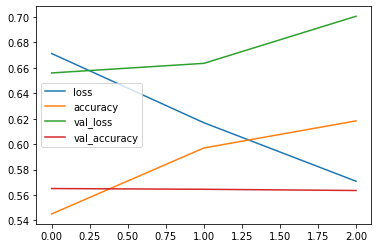

In [32]:
pd.DataFrame(history.history).plot()

In [33]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 0s 8ms/step - loss: 0.7046 - accuracy: 0.5545


Test score: 0.7046019434928894
Test accuracy: 0.5544567108154297


Лучше всего себя показала модель с LSTM. CNN -> LSTM тоже неплохо себя показала. А вот простой CNN и LSTM -> CNN показали результаты сильно хуже.